<a href="https://colab.research.google.com/github/arteagac/arteagac.github.io/blob/master/blog/lime_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIME for exaplanations of image classification

## Initialization

### Imports and InceptionV3 initialization

In [0]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import skimage
import skimage.segmentation
from PIL import Image
import requests
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook running: keras ', keras.__version__)

Notebook running: keras  2.2.5


In [0]:
from keras.applications import inception_v3 as inc_net
inceptionV3_model = inc_net.InceptionV3()

### Read image and make it the proper size to be processed with InceptionV3

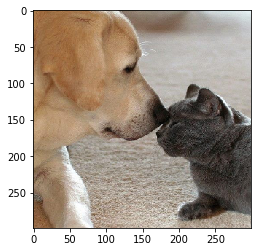

In [0]:
img_url = 'https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg'
Xi = image.img_to_array(Image.open(requests.get(img_url, stream=True).raw))
Xi = skimage.transform.resize(Xi, (299,299))
Xi = np.vstack(inc_net.preprocess_input(Xi[np.newaxis,:,:,:]))
Xi_orig = Xi / 2 + 0.5 #Before Inception Pre-processing
plt.imshow(Xi_orig)

### Use InceptionV3 model to predict

In [0]:
preds = inceptionV3_model.predict(np.expand_dims(Xi, axis=0))
top_pred_classes = preds[0].argsort()[-5:][::-1]
print(top_pred_classes)                #Index of top 5 classes
for i in decode_predictions(preds)[0]: #Top 5 classes
    print(i)

[208 207 180 243 246]
('n02099712', 'Labrador_retriever', 0.8221311)
('n02099601', 'golden_retriever', 0.015566514)
('n02093428', 'American_Staffordshire_terrier', 0.009475715)
('n02108422', 'bull_mastiff', 0.008317364)
('n02109047', 'Great_Dane', 0.007830384)


## LIME explanations

### Step 1: Create perturbations of image and compute predictions

#### Extract super-pixels from image

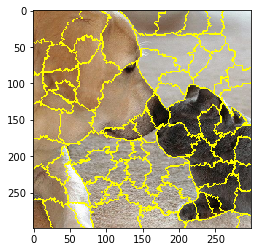

In [0]:
np.random.seed(444)
segments = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
plt.imshow(skimage.segmentation.mark_boundaries(Xi_orig, segments))
num_segments = np.unique(segments).shape[0]

#### Create random perturbations

In [0]:
num_perturb = 150
perturbations = np.random.randint(0, 2, num_perturb * num_segments).reshape((num_perturb, num_segments))
print(perturbations[0])

[1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0
 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0]


Function to perturb image based on perturbation vector

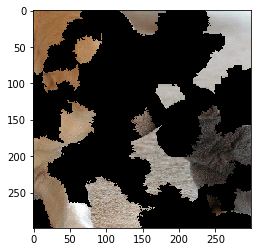

In [0]:
def perturb_image(img,perturbation,segments):
  zeros = np.where(perturbation == 0)[0]
  mask = np.zeros(segments.shape).astype(bool)
  for zero in zeros:
      mask[segments == zero] = True
  pert_image = copy.deepcopy(img)
  pert_image[mask] = np.zeros(img.shape)[mask]
  return pert_image

plt.imshow(perturb_image(Xi_orig,perturbations[0],segments))

### Step 2: Use ML classifier to predict classes of new generated image

In [0]:
classifier_fn = inceptionV3_model.predict
predictions = []
for pert in perturbations:
  pert_img = perturb_image(Xi,pert,segments)
  pred = classifier_fn(np.expand_dims(pert_img, axis=0))
  predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)

(150, 1, 1000)


### Step 3: Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image

In [0]:
distances = sklearn.metrics.pairwise_distances(perturbations,np.ones(num_segments).reshape(1, -1), metric='cosine').ravel()
print(distances.shape)

(150,)


#### Use kernel function to compute weights

<img src="https://arteagac.github.io/blog/lime_image/img/kernel.png" alt="Drawing" width="600"/>

In [0]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)

(150,)


### Step 4: Use `perturbations`, `predictions` and `weights` to fit an explainable (linear) model

In [0]:
class_to_explain = top_pred_classes[0]
simpler_model = Ridge(alpha=0, fit_intercept=True)
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
print(coeff)

[-0.03489399 -0.00174009  0.04093249 -0.01704106  0.08349461  0.06088286
  0.00871385  0.09065727  0.20279884 -0.03921386 -0.04442627  0.00348098
  0.04500267 -0.03139214  0.01854522  0.03574019 -0.02374427 -0.07200788
 -0.02285986  0.05616882 -0.02422539 -0.06033911 -0.02868346 -0.06979011
 -0.02694482  0.50434325  0.05677583  0.13657742 -0.00350217  0.06759293
  0.05737342  0.02294919  0.10189819 -0.02052239 -0.05476661  0.06461711
  0.0100655   0.04970987 -0.04603596 -0.04416816  0.03586438 -0.05175016
  0.01083958 -0.04612763  0.00722375 -0.07677641 -0.01883918  0.01988131
  0.01492523 -0.02956839 -0.01813172 -0.03330075 -0.04963128  0.03933446
 -0.02322406  0.05348434  0.02743462 -0.01379158  0.05866493  0.04128038
 -0.02566747 -0.1159331  -0.01538624  0.00710825  0.0313171  -0.05266197
 -0.05753472 -0.03019072 -0.00368765]


#### Compute top features (`num_features`)

In [0]:
num_top_features = 5
top_features = np.array([c[0] for c in sorted(zip(range(num_segments), coeff), key=lambda i: np.abs(i[1]), reverse=True)[:num_top_features] ])
print(top_features)

[25  8 27 61 32]


#### Show LIME explanation (image with top features)

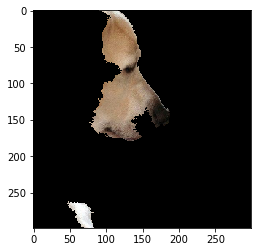

In [0]:
mask = np.zeros(num_segments)
mask[top_features]= True #Activate top segments
plt.imshow(perturb_image(Xi_orig,mask,segments))